# Block 6 Exercise 2: finding the best parameters for predicting the fare of taxi rides
We return to our Random Forest Regression and want to automatically optimize all free parameters ...

In [1]:
import pandas as pd
import numpy as np
import folium


In [2]:
# we load the data we have saved after wrangling and pre-processing in block I
X=pd.read_csv('../../DATA/train_cleaned.csv')
drop_columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','key','pickup_datetime','pickup_date','pickup_latitude_round3','pickup_longitude_round3','dropoff_latitude_round3','dropoff_longitude_round3']
X=X.drop(drop_columns,axis=1)
X=pd.get_dummies(X)# one hot coding
#generate labels
y=X['fare_amount']
X=X.drop(['fare_amount'],axis=1)

### Scikit Optimize
Scikit Optimize (https://scikit-optimize.github.io/stable/index.html) is a AutoML toolbox wrapped around Scikit-Learn. It allows us to use state-of-the-art automatic hyper-parameter optimization on top of our learning algorithms.   



In [3]:
# install
#!pip install scikit-optimize
#!pip install -U joblib
#!pip install -U matplotlib

### E 2.1 Bayesian Optimization of a Random Forest Regression Model
use Bayesian Optimization with Cross-Validation (https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV) to find the best regression model. Compare
* linear regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) 
* Random Forest regression (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
* and SVM regression (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)

NOTES: this can become quite compute intensive! Hence,
* use a smaller subset of the training data to run the experiments 
* think about the range of your parameters (e.g. larger number of trees in RF or high C-values in SMV will make models expensive)
* optimize only the following parameters per model type:
    * linear: no parameters to optimize
    * RF: #trees and depth
    * SVM: C and gamma (use RBF kernel)
* parallelize -> n_jobs
* use CoLab to rum the job for up to 12h 


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import matplotlib.pyplot as plt

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=42)
X_train.shape

(40000, 31)

In [7]:
my_data = {'model': [],
    'score': []}

model_score_table = pd.DataFrame(my_data)

param_search_linear = {
'n_estimators': Real(1e-6, 1e+6, prior='log-uniform'),
'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
'degree': Integer(1,8),
'kernel': Categorical(['linear', 'poly', 'rbf']),
}

In [17]:
%%time
linear = LinearRegression()
linear.fit(X_train, y_train)

score=linear.score(X_test, y_test)

model_score_table = model_score_table.append({'model': "LinearRegression",'score':score}, ignore_index=True)
print(score)

#Score: 0.768728628088388 ||| Wall time: 218 ms

0.7211331644200237
Wall time: 106 ms


In [18]:
n_iter_search = 30

param_search_regressor = {
    'n_estimators': (100, 200),
    'max_depth': (1, 8)
}



random_forest_search = BayesSearchCV(RandomForestRegressor(),param_search_regressor , n_iter=n_iter_search, random_state=0, n_jobs=-1)

print(random_forest_search.total_iterations)

60


In [19]:
%%time
rnd_forest = RandomForestRegressor(n_jobs=-1)
rnd_forest.fit(X_train, y_train)

score=rnd_forest.score(X_test, y_test)

model_score_table = model_score_table.append({'model': "RandomForestRegressor",'score':score}, ignore_index=True)
print(score)

#Score: 0.8376698922434437 ||| Wall time: 5min 44s

0.7994969493426815
Wall time: 7.96 s


In [20]:
%%time
random_forest_search.fit(X_train, y_train)
print(random_forest_search.best_params_)

score=random_forest_search.best_score_

model_score_table = model_score_table.append({'model': "BayesSearchCV_RandomForestRegressor",'score':score}, ignore_index=True)
print(score)

#Score:  ||| Wall time: 

C:\Users\Anthony\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Anthony\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Anthony\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Anthony\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Anthony\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Us

OrderedDict([('max_depth', 8), ('n_estimators', 200)])
0.8156670229592776
Wall time: 11min 34s


In [21]:
pipeline_SVR = make_pipeline(StandardScaler(), SVR(kernel='rbf'))
pipeline_SVR.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svr', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svr__C', 'svr__cache_size', 'svr__coef0', 'svr__degree', 'svr__epsilon', 'svr__gamma', 'svr__kernel', 'svr__max_iter', 'svr__shrinking', 'svr__tol', 'svr__verbose'])

In [22]:
n_iter_search = 20

param_search_regressor = {
    'svr__C': (1, 15),
    'svr__gamma': ['scale', 'auto']
}



pipeline_SVR_search = BayesSearchCV(pipeline_SVR, param_search_regressor , n_iter=n_iter_search, random_state=0, n_jobs=-1)

print(pipeline_SVR_search.total_iterations)

40


In [23]:
%%time
pipeline_SVR.fit(X_train, y_train)

score=pipeline_SVR.score(X_test, y_test)

model_score_table = model_score_table.append({'model': "StandardScaler_SVR",'score':score}, ignore_index=True)
print(score)

#Score:  ||| Wall time: 

0.7418881144949554
Wall time: 11min 59s


In [24]:
%%time
pipeline_SVR_search.fit(X_train, y_train)
print(pipeline_SVR_search.best_params_)

score=pipeline_SVR_search.best_score_

model_score_table = model_score_table.append({'model': "BayesSearchCV_StandardScaler_SVR",'score':score}, ignore_index=True)
print(score)

#Score:  ||| Wall time: 

C:\Users\Anthony\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


OrderedDict([('svr__C', 15), ('svr__gamma', 'scale')])
0.7788066595323522
Wall time: 1h 4min


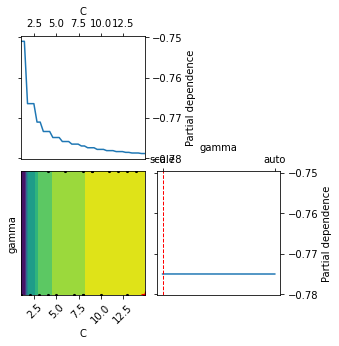

In [25]:
from skopt.plots import plot_objective, plot_histogram

_ = plot_objective(pipeline_SVR_search.optimizer_results_[0],
                   dimensions=["C", "gamma"],
                   n_minimum_search=int(1e8))
plt.show()

In [26]:
model_score_table

,model,score
0,LinearRegression,0.721133
1,LinearRegression,0.721133
2,RandomForestRegressor,0.799497
3,BayesSearchCV_RandomForestRegressor,0.815667
4,StandardScaler_SVR,0.741888
5,BayesSearchCV_StandardScaler_SVR,0.778807


In [33]:
import pickle 
pickle.dump(linear, open( "LinearRegression_model.p", "wb" ) ) #seave model to fiel
pickle.dump(rnd_forest, open( "RandomForestRegressor_model.p", "wb" ) ) #seave model to fiel
pickle.dump(random_forest_search, open( "BayesSearchCV_RandomForestRegressor_model.p", "wb" ) ) #seave model to fiel
pickle.dump(pipeline_SVR, open( "StandardScaler_SVR_model.p", "wb" ) ) #seave model to fiel
pickle.dump(pipeline_SVR_search, open( "BayesSearchCV_StandardScaler_SVR_model.p", "wb" ) ) #seave model to fiel

In [36]:
model_BayesSearchCV_StandardScaler_SVR = pickle.load(open( "BayesSearchCV_StandardScaler_SVR_model.p", "rb" ) )#load model from firl
print(model_BayesSearchCV_StandardScaler_SVR.best_score_)
print(model_BayesSearchCV_StandardScaler_SVR.best_params_)

0.7788066595323522
OrderedDict([('svr__C', 15), ('svr__gamma', 'scale')])


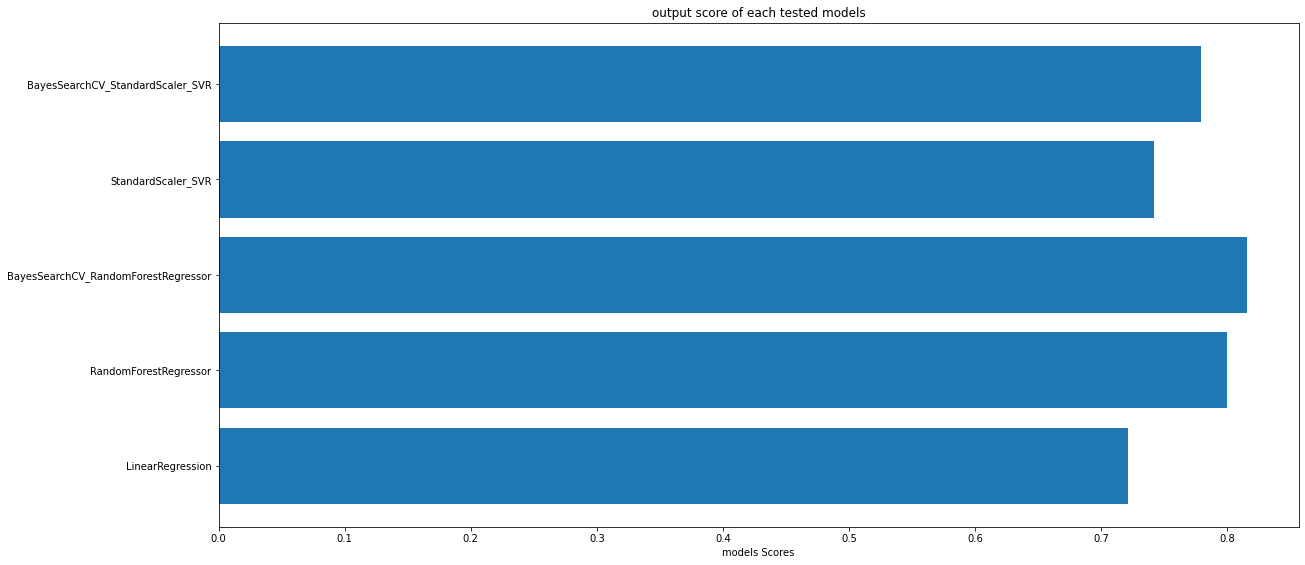

In [48]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
ax.barh(model_score_table.model, model_score_table.score)
ax.set_title('output score of each tested models')
ax.set_xlabel('models Scores')
plt.show()

As we can see here, there is already an improvement between both randomforest and SVR estimator and their respectively optimized counterpart. But the overall score is not that hight because of the train data length. Here I did take 40k for train data which ended up with already 1h computation. This mean that with the whole dataset, it could take more than 10h.
However I had trouble using colab for more than 2h whithout being disconnected.